In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import joblib

In [4]:
# Load the data
data = pd.read_csv('df_all.csv')

### Data Cleanning

In [5]:
# Rename columns for clarity
data.rename(columns={'Pos_x': 'Position', 'Pos_y': 'Draft_Position'}, inplace=True)
# Replace the '-' in 'Ht' with '.' and convert to float
data['Ht'] = data['Ht'].str.replace('-', '.').astype(float)
# Drop the 'Unnamed: 0' column as it's just an index
data.drop(columns=['Unnamed: 0'], inplace=True)
# Handling missing values
numerical_columns = ['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Age']
# Group by 'Position' and fill missing numerical values with the median of that group
for col in numerical_columns:
    data[col] = data.groupby('Position')[col].transform(lambda x: x.fillna(x.median()))
# Note: This approach will leave NaNs intact if a particular position group doesn't have any non-NaN values for a column
# So, as a fallback, fill remaining NaNs with the overall median
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())
# Handling NaN values in 'Rnd' and 'Pick' with a placeholder value
data['Rnd'].fillna(-1, inplace=True)
data['Pick'].fillna(-1, inplace=True)
# Handling NaN values in 'Tm' and 'Draft Position' with a string 'Undrafted'
data['Tm'].fillna('Undrafted', inplace=True)
data['Draft_Position'].fillna('Undrafted', inplace=True)

/home/gabot/Documents/datascience/nfl_draft/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/gabot/Documents/datascience/nfl_draft/myenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


### Feature Engineering

BMI (Body Mass Index)

In [6]:
# Convert height from feet to meters (1 foot = 0.3048 meters)
data['Ht_m'] = data['Ht'] * 0.3048
# Convert weight from pounds to kilograms (1 pound = 0.453592 kilograms)
data['Wt_kg'] = data['Wt'] * 0.453592
# Calculate BMI
data['BMI'] = data['Wt_kg'] / (data['Ht_m'] ** 2)

In [7]:
# Define a function to calculate the index based on position
def calculate_position_index(row):
    if row['Position'] == 'WR':
        return row['40yd'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'CB':
        return row['40yd'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'RB':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'S':
        return row['40yd'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'OT':
        return row['40yd'] + row['Bench'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'DE':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'DT':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'OLB':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'TE':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'QB':
        return row['40yd'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'OG':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'ILB':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'C':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'LB':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'OL':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'FB':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'DL':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'EDGE':
        return row['40yd'] + row['Bench'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    elif row['Position'] == 'DB':
        return row['40yd'] + row['Vertical'] + row['Broad Jump'] + row['3Cone'] + row['Shuttle']
    else:
        return 0  # Default value for other positions

In [8]:
# Apply the function to each row
data['Position_Performance_Index'] = data.apply(calculate_position_index, axis=1)

In [9]:
# Save the cleaned data (optional)
data.to_csv('cleaned_df.csv', index=False)

### Exploratory Data Analysis (EDA)

In [10]:
# Summary statistics
print(data.describe())

                Ht           Wt         40yd     Vertical        Bench  \
count  7686.000000  7686.000000  7686.000000  7686.000000  7686.000000   
mean      6.075713   242.693794     4.777555    32.850059    20.082292   
std       0.455551    45.220932     0.301377     3.922108     5.827572   
min       5.100000   144.000000     4.220000    17.500000     2.000000   
25%       6.000000   205.000000     4.540000    30.000000    15.000000   
50%       6.200000   232.000000     4.700000    33.000000    19.500000   
75%       6.400000   280.000000     4.970000    35.500000    24.000000   
max       6.900000   384.000000     6.050000    46.500000    49.000000   

        Broad Jump        3Cone      Shuttle      drafted          Rnd  \
count  7686.000000  7686.000000  7686.000000  7686.000000  7686.000000   
mean    114.456024     7.257050     4.384748     0.627114     2.063882   
std       8.780606     0.376837     0.241730     0.483604     2.817771   
min      74.000000     6.280000     3

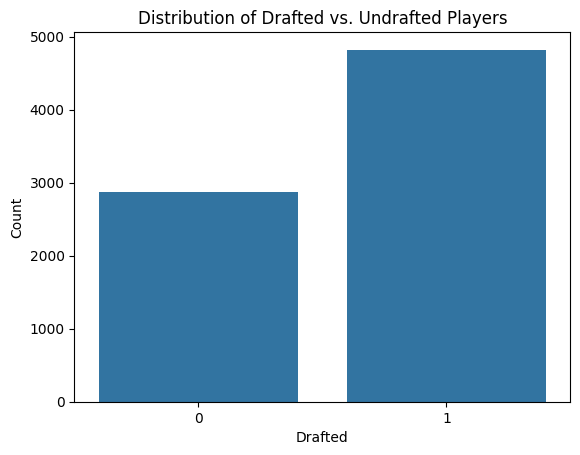

In [11]:
# Distribution of the 'drafted' column
sns.countplot(x='drafted', data=data)
plt.title('Distribution of Drafted vs. Undrafted Players')
plt.xlabel('Drafted')
plt.ylabel('Count')
plt.show()

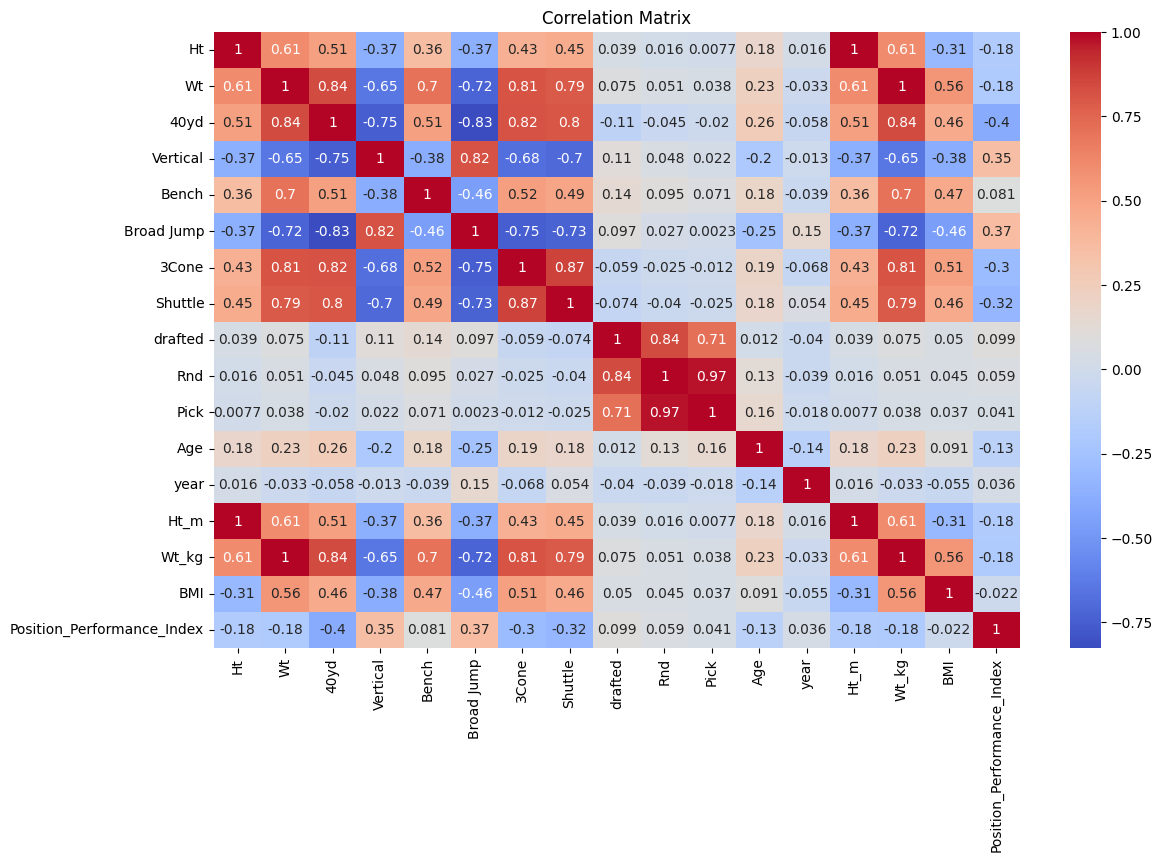

In [12]:
plt.figure(figsize=(13, 8))
# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


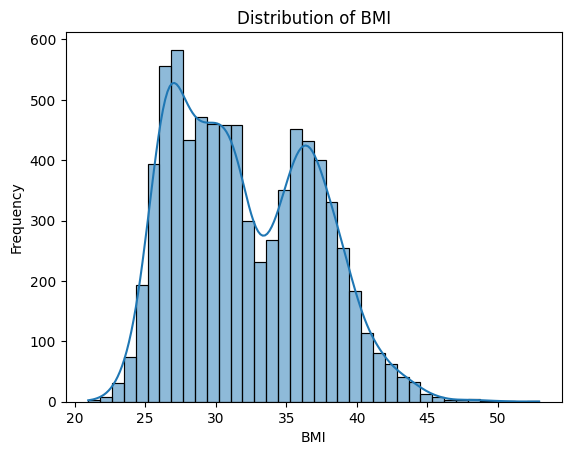

In [13]:
# Histogram of BMI
sns.histplot(data['BMI'], kde=True)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

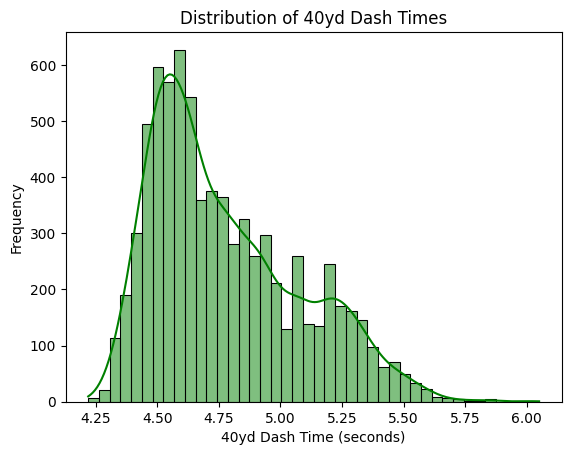

In [14]:
# Histogram of 40yd Dash Times
sns.histplot(data['40yd'], kde=True, color='green')
plt.title('Distribution of 40yd Dash Times')
plt.xlabel('40yd Dash Time (seconds)')
plt.ylabel('Frequency')
plt.show()

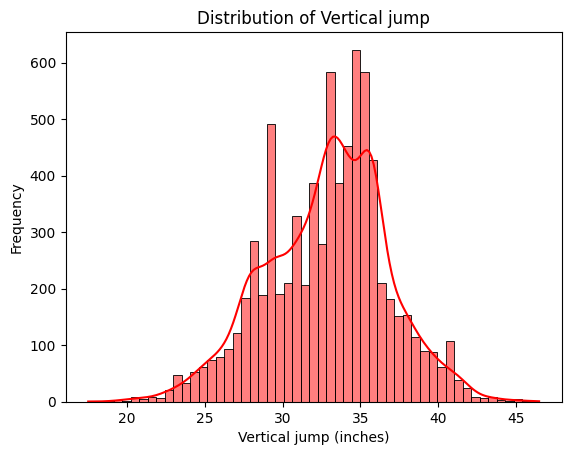

In [15]:
# Histogram of Vertical jump
sns.histplot(data['Vertical'], kde=True, color='red')
plt.title('Distribution of Vertical jump')
plt.xlabel('Vertical jump (inches)')
plt.ylabel('Frequency')
plt.show()

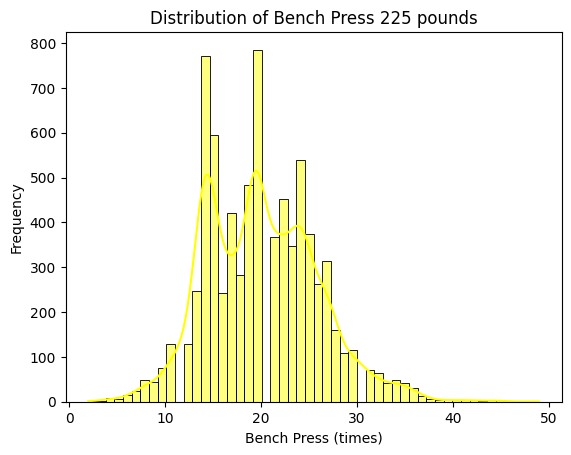

In [16]:
# Histogram of Bench press
sns.histplot(data['Bench'], kde=True, color='yellow')
plt.title('Distribution of Bench Press 225 pounds')
plt.xlabel('Bench Press (times)')
plt.ylabel('Frequency')
plt.show()

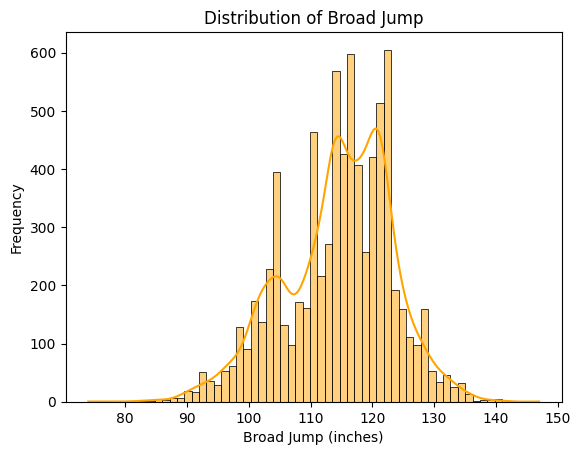

In [17]:
# Histogram of Broad Jump
sns.histplot(data['Broad Jump'], kde=True, color='orange')
plt.title('Distribution of Broad Jump')
plt.xlabel('Broad Jump (inches)')
plt.ylabel('Frequency')
plt.show()

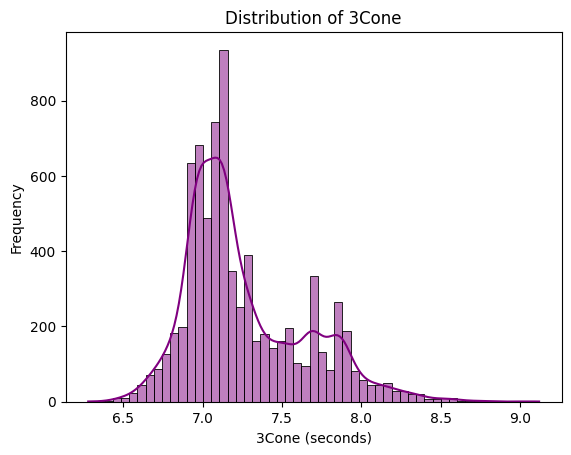

In [18]:
# Histogram of 3Cone
sns.histplot(data['3Cone'], kde=True, color='purple')
plt.title('Distribution of 3Cone')
plt.xlabel('3Cone (seconds)')
plt.ylabel('Frequency')
plt.show()

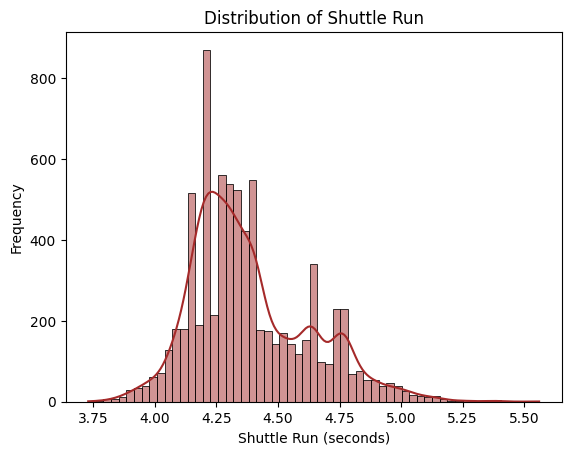

In [19]:
# Histogram of Shuttle Run
sns.histplot(data['Shuttle'], kde=True, color='brown')
plt.title('Distribution of Shuttle Run')
plt.xlabel('Shuttle Run (seconds)')
plt.ylabel('Frequency')
plt.show()

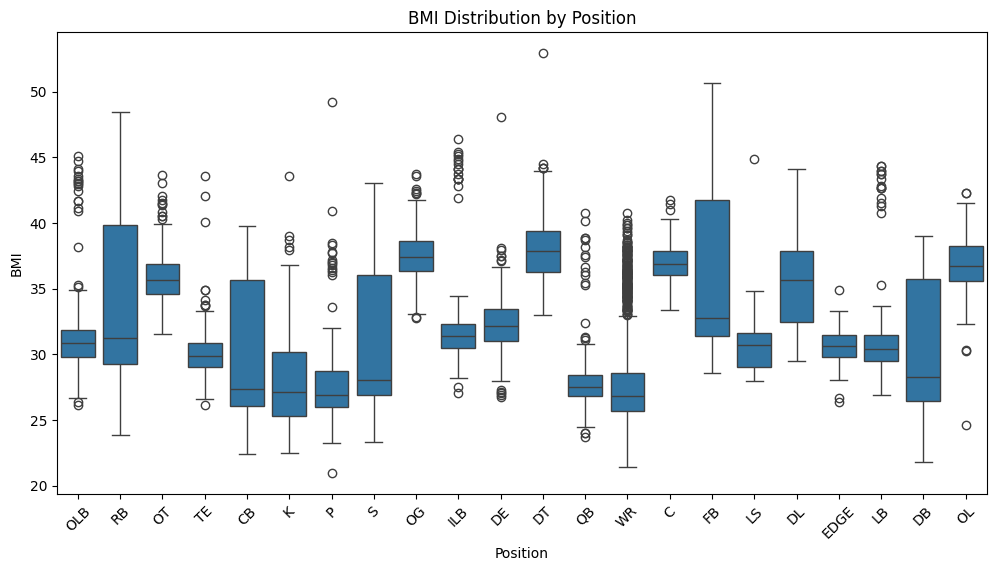

In [20]:
# Compare distributions of numerical data across categories like player positions
plt.figure(figsize=(12, 6))
sns.boxplot(x='Position', y='BMI', data=data)
plt.title('BMI Distribution by Position')
plt.xticks(rotation=45)
plt.xlabel('Position')
plt.ylabel('BMI')
plt.show()

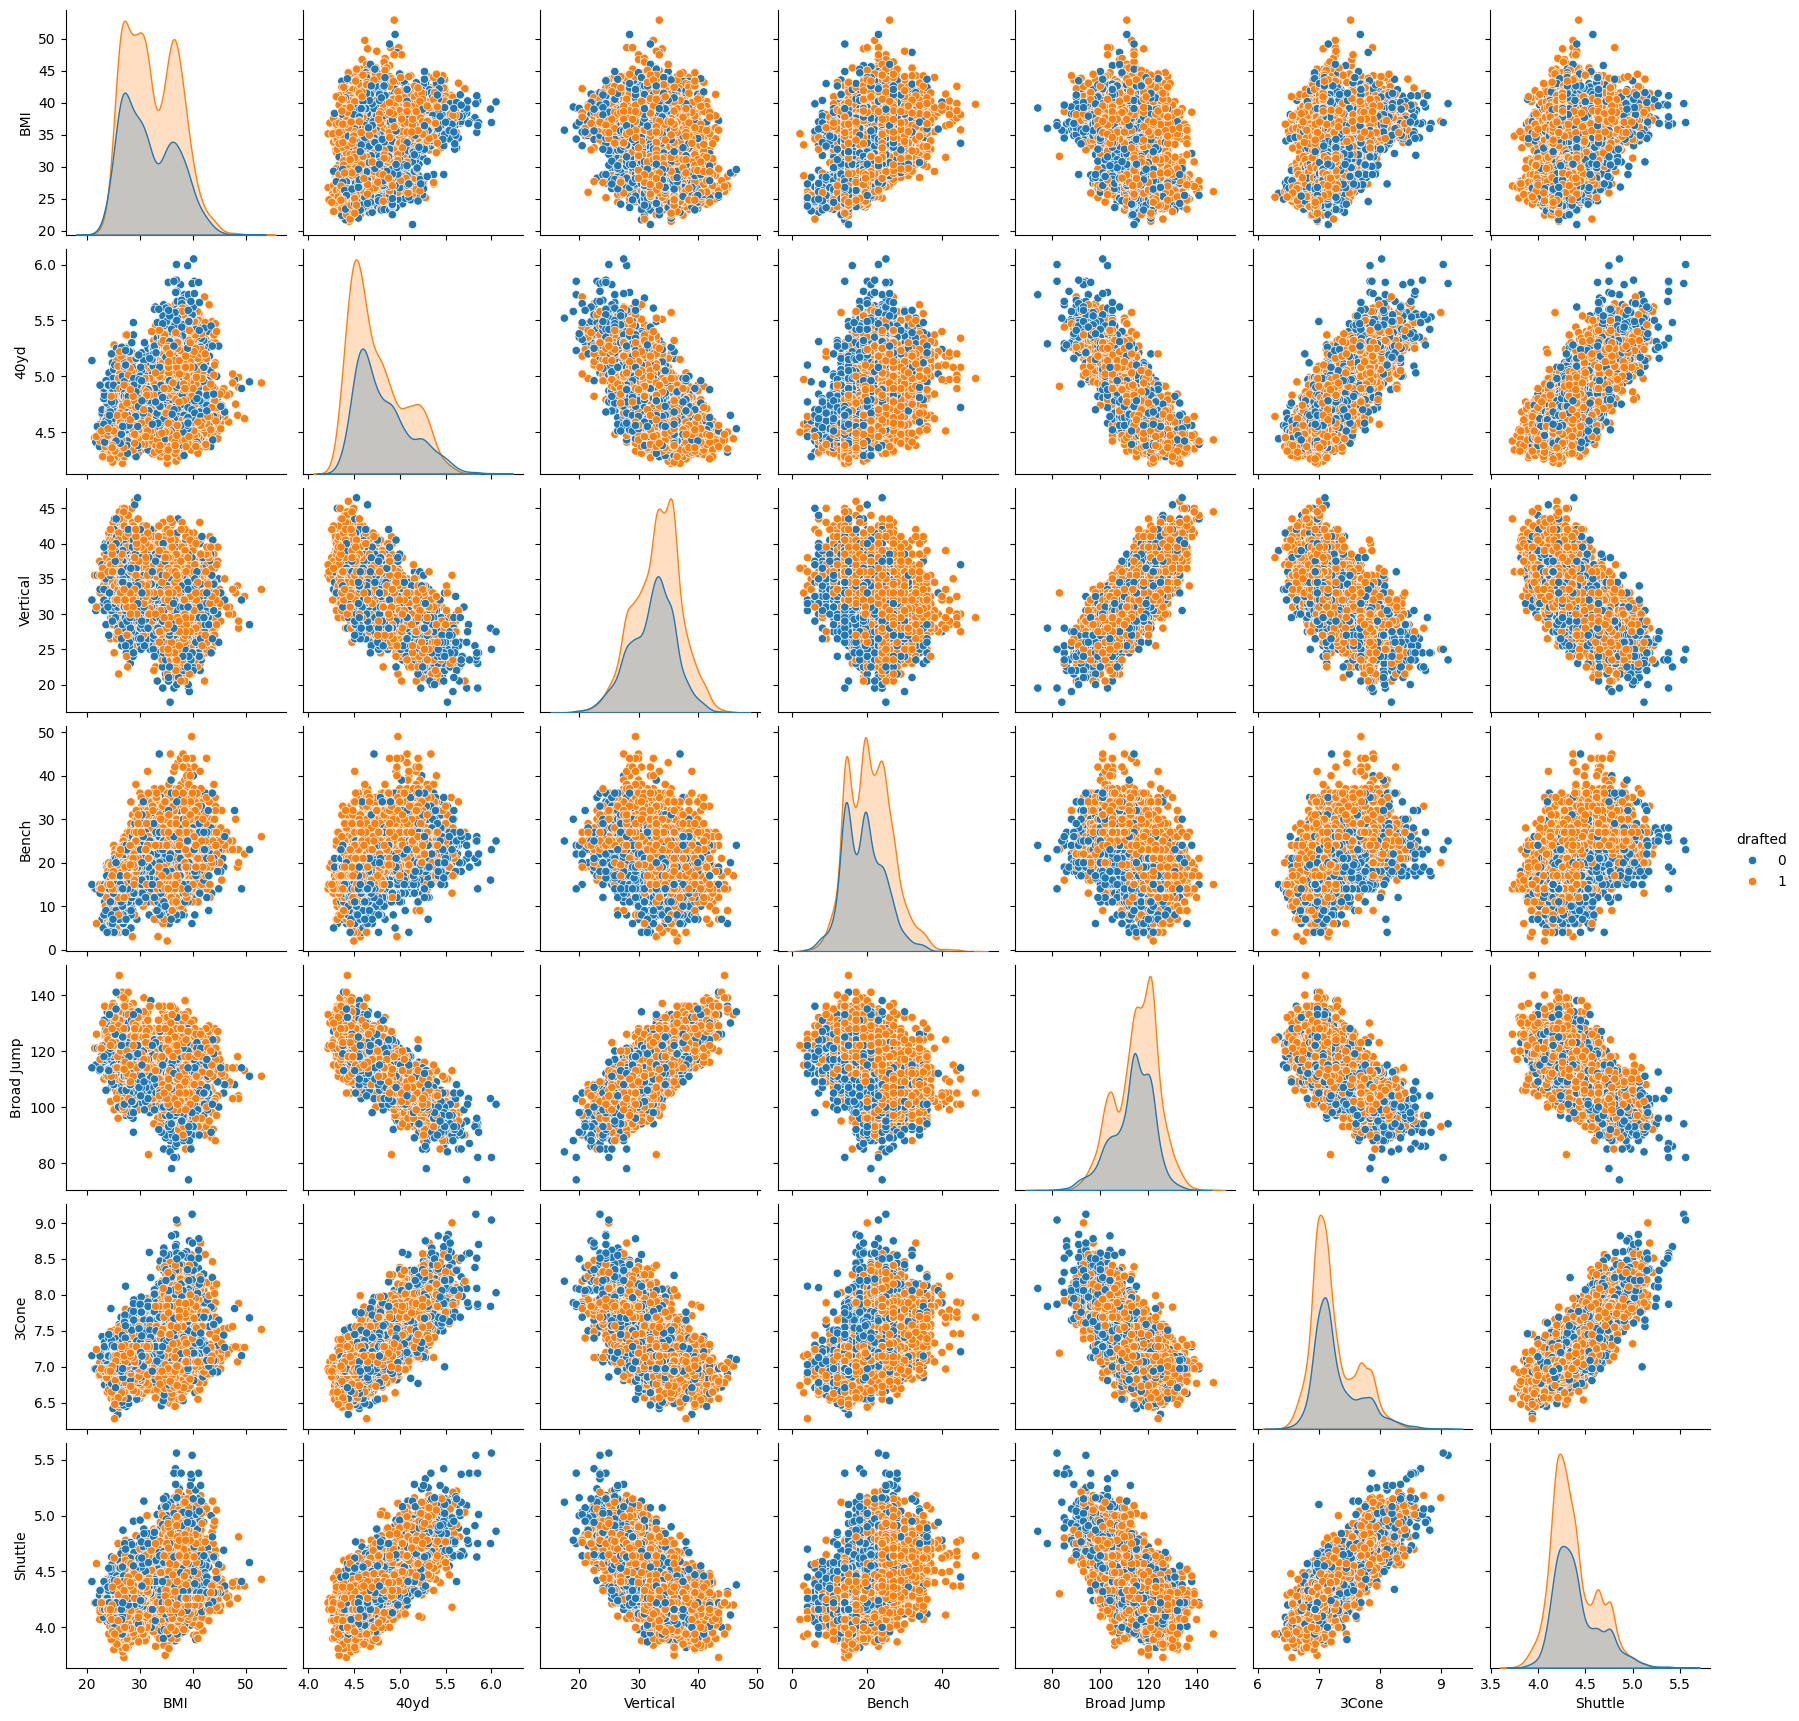

In [21]:
# Visualize relationships between pairs of features
sns.pairplot(data[['BMI', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'drafted']], hue='drafted')
plt.show()

### Feature Selection

In [31]:
# Scale the data
X = data[['Ht', '40yd', 'Vertical', 'Bench', 'Age']]  
y = data['drafted']  

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your data
X_scaled = scaler.fit_transform(X)

In [32]:
# Create a logistic regression classifier
model = LogisticRegression(max_iter=1000)  

# Create the RFE model and select 5 attributes
rfe = RFE(model, n_features_to_select=5)
rfe = rfe.fit(X_scaled, y)

# Summarize the selection of the attributes
print('Selected features:', X.columns[rfe.support_])

Selected features: Index(['Ht', '40yd', 'Vertical', 'Bench', 'Age'], dtype='object')


### Data Splitting

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


### Model Training

In [36]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Model Evaluation

In [39]:
# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.723667100130039
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       556
           1       0.78      0.80      0.79       982

    accuracy                           0.72      1538
   macro avg       0.70      0.70      0.70      1538
weighted avg       0.72      0.72      0.72      1538



In [43]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth' : [4, 5, 6, 7, 8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200, 300]})

In [46]:
# Save the best model from grid search
joblib.dump(CV_rfc.best_estimator_, 'optimized_random_forest_model.joblib')

['optimized_random_forest_model.joblib']